# Vesuvius EDA ([kaggle notebook](https://www.kaggle.com/code/thenoodleninja/exploratory-data-analysis))

In this notebook some basic EDA and preprocessing will be performed on the [vesuvius-challenge-ink-detection](https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection) dataset.

This dataset consists of three Herculaneum roll fragments of differing sizes. If one looks into the folder of one of those fragments, one finds the following files:
 - **ir.png**: An IR image of the fragment on which the ink is clearly visible. This was used to generate the ink mask.
 - **inklabels.png**: The target mask, specifying the location of ink on the papyrus.
fig, ax = plt.subplots(3, 2)
for i, fragment_path in enumerate(train_fragments):
    plot_cross_section(ax[i, 0], ScanData(fragment_path))
    ax[i, 0].set_title(f"fragment {fragment_path.name}, y=4000, x=1500:1900")
    plot_cross_section(ax[i, 1], ScanData(fragment_path), y=slice(3800, 4200), x=1700)
    ax[i, 1].set_title(f"fragment {fragment_path.name}, y=4000, x=1500:1900")
fig.set_figwidth(20)
fig.tight_layout()
plt.show() 
 - **mask.png**: A binary mask, seperating the papyrus from the background.
 - **surface_volume/\<i\>.tif**: The i-th layer of the x-ray volume. 

In [1]:
# imports
import cv2
import numpy as np
import os
import gc
import glob
import json
from pathlib import Path
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont

MAX_UINT16 = int(2**16-1)

In [2]:
# get fragment paths
base_path = Path("/kaggle/input/vesuvius-challenge-ink-detection")
train_path = base_path / "train"
train_fragments = sorted([train_path  / f.name for f in train_path.iterdir()])
test_path = base_path / "test"
test_fragments = sorted([test_path  / f.name for f in test_path.iterdir()])

allFragments = train_fragments + test_fragments

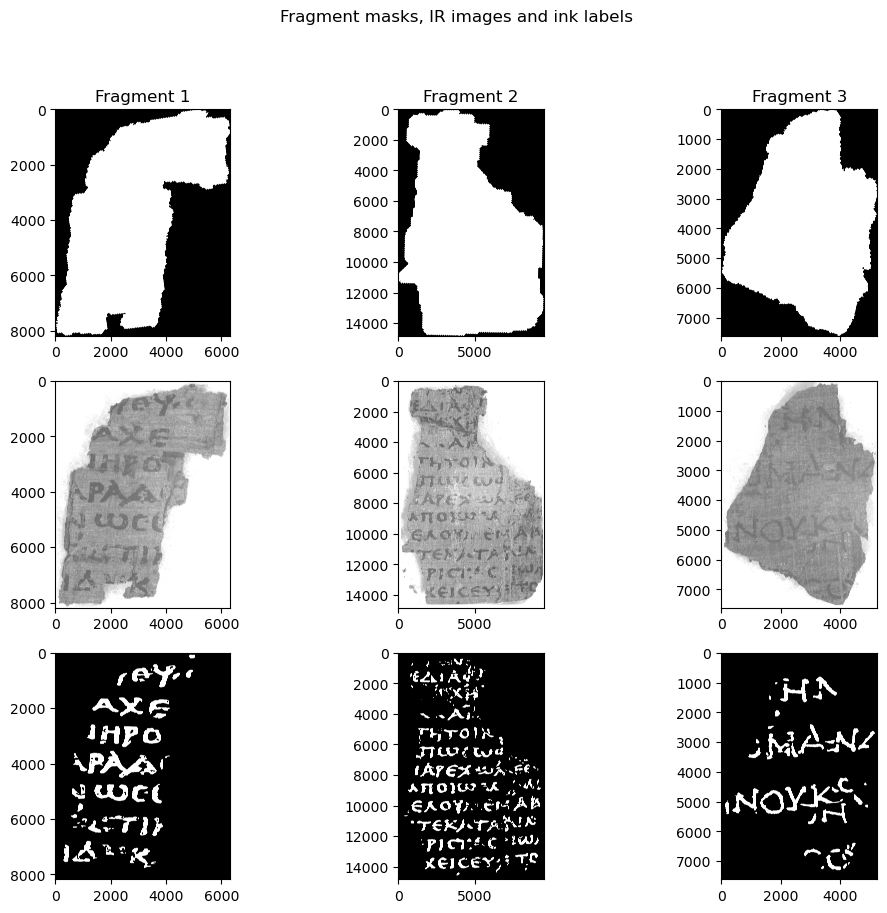

In [3]:
# Show individual fragments with corresponding masks and labels

fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(10)
for i, fragment_path in enumerate(train_fragments):
    mask = cv2.imread(str(fragment_path / "mask.png"))
    ir = cv2.imread(str(fragment_path / "ir.png"))
    label = cv2.imread(str(fragment_path / "inklabels.png"))
    axs[0, i].imshow(mask)
    axs[0, i].set_title(f"Fragment {fragment_path.name}")
    axs[1, i].imshow(ir)
    axs[2, i].imshow(label)
fig.suptitle("Fragment masks, IR images and ink labels")
plt.show()

In [4]:
# Create gifs for individual fragment that loop through the 65 layers 

output_folder = Path("/kaggle/working/visualizations")
font = ImageFont.load_default()

os.makedirs(output_folder, exist_ok=True)
for fragment_id in range(1, 4):
    
    volume_folder = base_path / 'train' / str(fragment_id) / "surface_volume"
    frames = []
    # load and resize layers
    for i, image in tqdm(enumerate(sorted(glob.glob(str(volume_folder / "*.tif"))))):
        img = Image.open(image)
        width, height = img.size
        img = Image.fromarray((np.array(img.resize((width//8, height//8)))//255).astype(np.uint8))
        d = ImageDraw.Draw(img)
        d.text( (30, 30), f"{i:02}", fill=(255))
        frames.append(img)

    # save individual layers as a looping gif
    frames[0].save(output_folder / f"x-ray_{fragment_id}.gif", format="GIF", append_images=frames[1:],
               save_all=True, duration=100, loop=0)

65it [02:52,  2.65s/it]
0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:3170: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
65it [05:59,  5.53s/it]
65it [02:30,  2.31s/it]


In [4]:
def mem_efficient_index(X, mask):
    masked_layers = []
    for x in X:
        masked_layers.append(x[mask])
    return np.concatenate(masked_layers)

def flatten(arr, z_buffer=2, z_layers=7, blur_topo = True):
    """
    :param arr: numpy array with the surface_volume_data
    :param z_buffer: how much air we will leave above the papyrus
    :param z_layers: how much layers we want to keep after transsforming
    :return:
    """
    arr = arr.astype(float) / (2**16-1) # convert to float
    arr = np.flip(arr, axis=0)
    arr = gaussian_filter(arr, sigma=1)
    arr_sob = ndimage.sobel(arr, axis=0)
    arr_sob = gaussian_filter(arr, sigma=1)
    topo = np.argmax(np.where(arr_sob < 0.5, 0, 1), axis=0)
    del arr_sob
    if blur_topo:
        topo=gaussian_filter(topo,sigma=1)
    arr_idx = np.indices(arr.shape)
    arr = arr[
        (arr_idx[0] + topo - z_buffer) % arr.shape[0], arr_idx[1], arr_idx[2]]
    arr = (arr[0:z_layers]*(2**16-1)).astype(np.uint16)
    return arr, topo.astype(np.uint8)

class ScanData:
    def __init__(self, baseDir, cache_folder="/tmp"):
        self.id = hash(str(baseDir))
        self.dir = baseDir.resolve()
        maskName = str(baseDir / "mask.png")
        mask = np.array(Image.open(maskName).convert("1"))        
        self.mask = mask
        (self.h,self.w) = mask.shape

        labelName = str(baseDir / "inklabels.png" )
        try:
            self.label = np.array(Image.open(labelName).convert("1"))        
        except:
            self.label = None

        self.sliceNames = sorted( (baseDir / "surface_volume").rglob("*.tif") )
        dim = len(self.sliceNames)
        self.dim = dim
        self.cache_folder=cache_folder
    
    def get_img_uint16(self, z_slc: slice=slice(None, None), y_slc:slice=slice(None, None), x_slc:slice=slice(None, None)):
        if not os.path.isfile(f"{self.cache_folder}/{self.id}_uint16.npy"):
            print("caching img")
            os.makedirs(f"{self.cache_folder}", exist_ok= True)
            
            img = np.zeros((self.dim, self.h, self.w), dtype=np.uint16)
            for idx, filename in enumerate(tqdm(self.sliceNames, leave=False)):
                fname = str(filename)
                img[idx, :, :] = np.array(Image.open(fname))
            np.save(f"{self.cache_folder}/{self.id}_uint16.npy", img)
            
        return np.load(f'{self.cache_folder}/{self.id}_uint16.npy', mmap_mode='r')[z_slc, y_slc, x_slc].copy()
    
    def get_img_uint8(self, z_slc: slice=slice(None, None), y_slc:slice=slice(None, None), x_slc:slice=slice(None, None)):
        if not os.path.isfile(f"{self.cache_folder}/{self.id}_uint8.npy"):
            print("caching img")
            os.makedirs(f"{self.cache_folder}", exist_ok= True)

            img = np.zeros((self.dim, self.h, self.w), dtype=np.uint8)
            for idx, filename in enumerate(tqdm(self.sliceNames, leave=False)):
                fname = str(filename)
                img[idx, :, :] = (np.array(Image.open(fname))//256).astype(np.uint8)
            np.save(f"{self.cache_folder}/{self.id}_uint8.npy", img)

        return np.load(f'{self.cache_folder}/{self.id}_uint8.npy', mmap_mode='r')[z_slc, y_slc, x_slc].copy()
    
    def flatten(self, z_layers=7, stripe_width=500, stripe_overlay = 20):
        flattened = np.zeros((z_layers, self.h, self.w), dtype=np.uint16)
        topo = np.zeros((self.h, self.w), dtype=np.uint8)
        for i in tqdm(range(0,self.h, stripe_width)):
            y0=max(i-stripe_overlay,0)
            y1=min(i+stripe_width+stripe_overlay,self.h)

            img_stripe = self.get_img_uint16(y0=y0, y1=y1)
            stripe_flat, stripe_topo = flatten(img_stripe, 2, z_layers)
            if y0 == 0:
                flattened[:, i:min(i+stripe_width, self.h), :] = stripe_flat[:, 0:min(stripe_width, stripe_flat.shape[1]), :]
                topo[i:min(i+stripe_width, self.h), :] = stripe_topo[0:min(stripe_width, stripe_topo.shape[0]), :]
            else:
                flattened[:, i:min(i+stripe_width, self.h), :] = stripe_flat[:, stripe_overlay:min(stripe_width+stripe_overlay, stripe_flat.shape[1]), :] 
                topo[i:min(i+stripe_width, self.h), :] = stripe_topo[stripe_overlay:min(stripe_width+stripe_overlay, stripe_topo.shape[0]), :] 
        return flattened, topo
    
    def save_flattened(self, folder):
        os.makedirs(f"{folder}/surface_volume", exist_ok= True)
        
        flattened, topo = self.flatten()
        # saving layers
        for i in tqdm(range(flattened.shape[0])):
            layer = Image.fromarray(flattened[i])
            layer.save(f"{folder}/surface_volume/{i:02}.tif")
        layer = Image.fromarray(topo)
        layer.save(f"{folder}/topo.png")

caching img


caching img


caching img


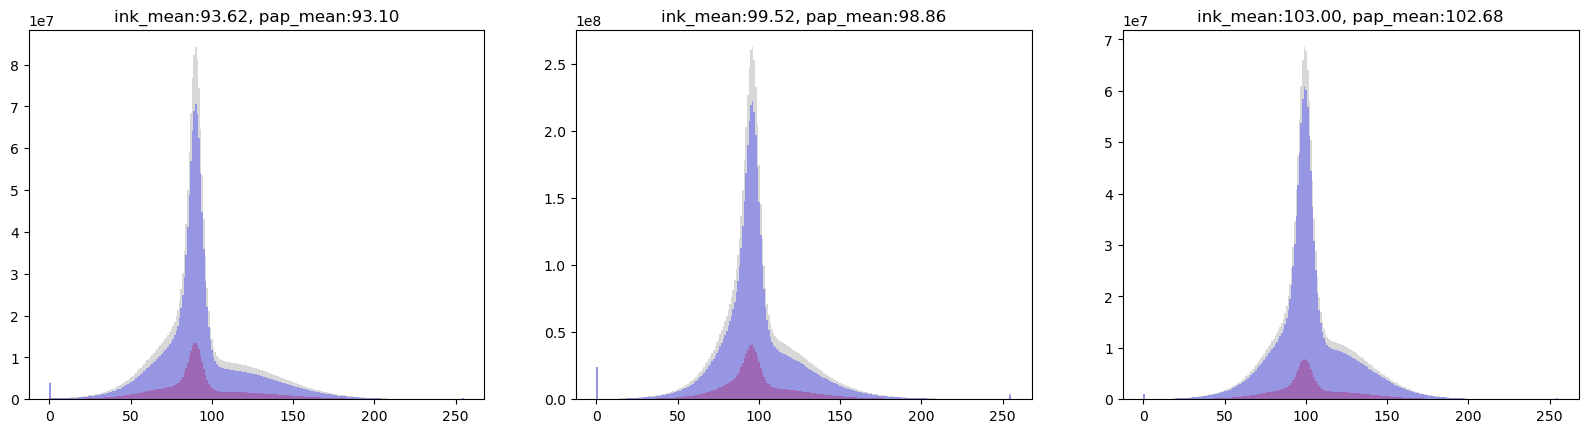

In [6]:
# visualize intensity distributions for ink (red), papyrus (blue) and everything (grey)
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
for i, fragment_path in enumerate(train_fragments):
    # read data
    scan = ScanData(fragment_path)
    full = scan.get_img_uint8()      
    label_name = fragment_path / "inklabels.png"
    label = np.array(Image.open(label_name), dtype=bool)

    # plot papyrus and ink hist
    axs[i].hist(mem_efficient_index(full, scan.mask), bins=256, alpha=0.3, color="gray")
    
    ink = mem_efficient_index(full, label)
    ink_mean = ink.mean()
    axs[i].hist(ink, bins=256, alpha=0.3, color="red")
    del ink
    gc.collect()
    
    pap = mem_efficient_index(full, scan.mask & np.logical_not(label))
    pap_mean = pap.mean()
    axs[i].hist(pap, bins=256, alpha=0.3, color="blue")
    del pap
    gc.collect()
    
    axs[i].set_title(f"ink_mean:{ink_mean:.2f}, pap_mean:{pap_mean:.2f}")
    del scan, full, label
    gc.collect()
plt.show()

In [7]:
N = 5

fragment_data = []
for i, fragment_path in enumerate(train_fragments):
    scan = ScanData(fragment_path)
    label_name = fragment_path / "inklabels.png"
    label = np.array(Image.open(label_name), dtype=bool)
    
    paps, inks = [], []
    for n in tqdm(range(65-N)):
        z0, z1 = n, n+N
        slc = scan.get_img_uint8(z_slc=slice(z0, z1))
        
        paps.append(mem_efficient_index(slc, scan.mask & np.logical_not(label)).mean())
        inks.append(mem_efficient_index(slc, label).mean())
    fragment_data.append((paps, inks))

100%|██████████| 60/60 [00:38<00:00,  1.56it/s]


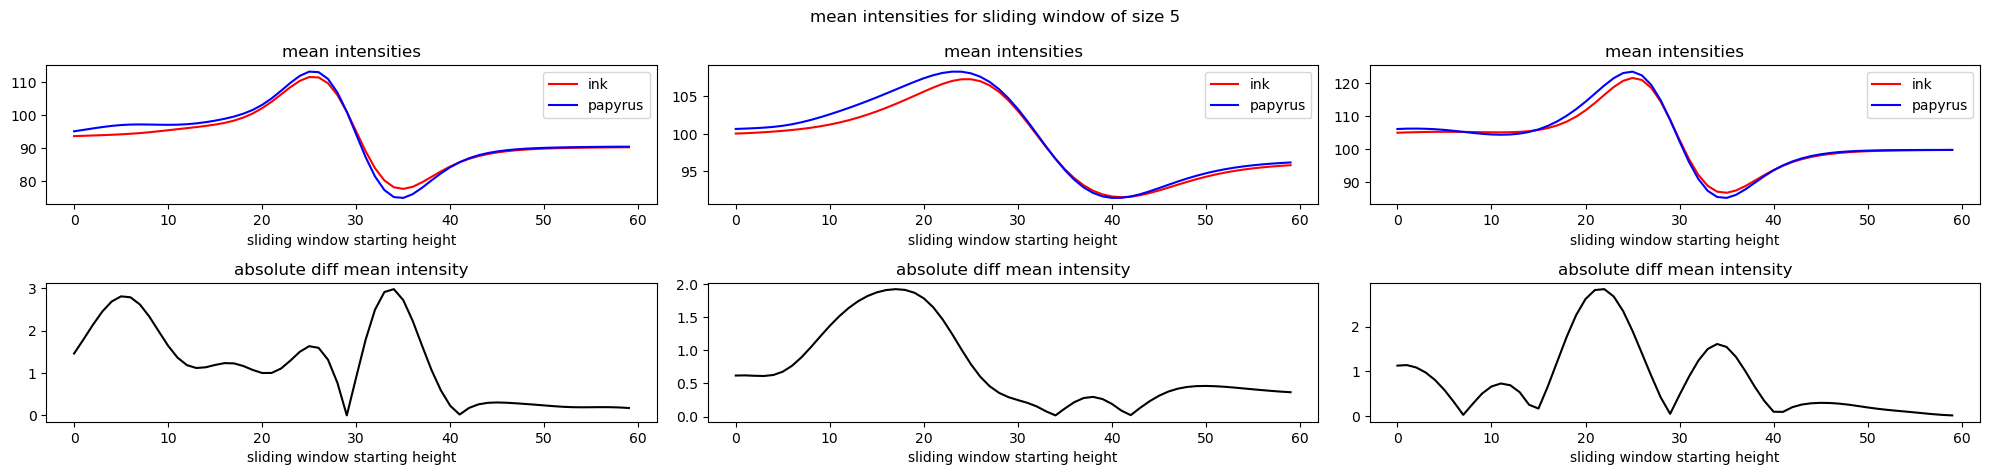

In [8]:
fig, axs = plt.subplots(2, 3)
for i, fragment_path in enumerate(train_fragments):
    inks, paps = fragment_data[i]
    ax0, ax1 = axs[:, i]
    ink, = ax0.plot(inks, color="red", label="ink")
    pap, = ax0.plot(paps, color = "blue", label="papyrus")
    ax0.set_title("mean intensities")
    ax0.set_xlabel("sliding window starting height")
    ax0.legend(handles=[ink, pap])
    ax1.plot(abs(np.array(inks)-np.array(paps)), color="black", label="|ink-pap|")
    ax1.set_title("absolute diff mean intensity")
    ax1.set_xlabel("sliding window starting height")
    gc.collect()
fig.suptitle(f"mean intensities for sliding window of size {N}")
fig.set_figwidth(20)
fig.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:3170: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


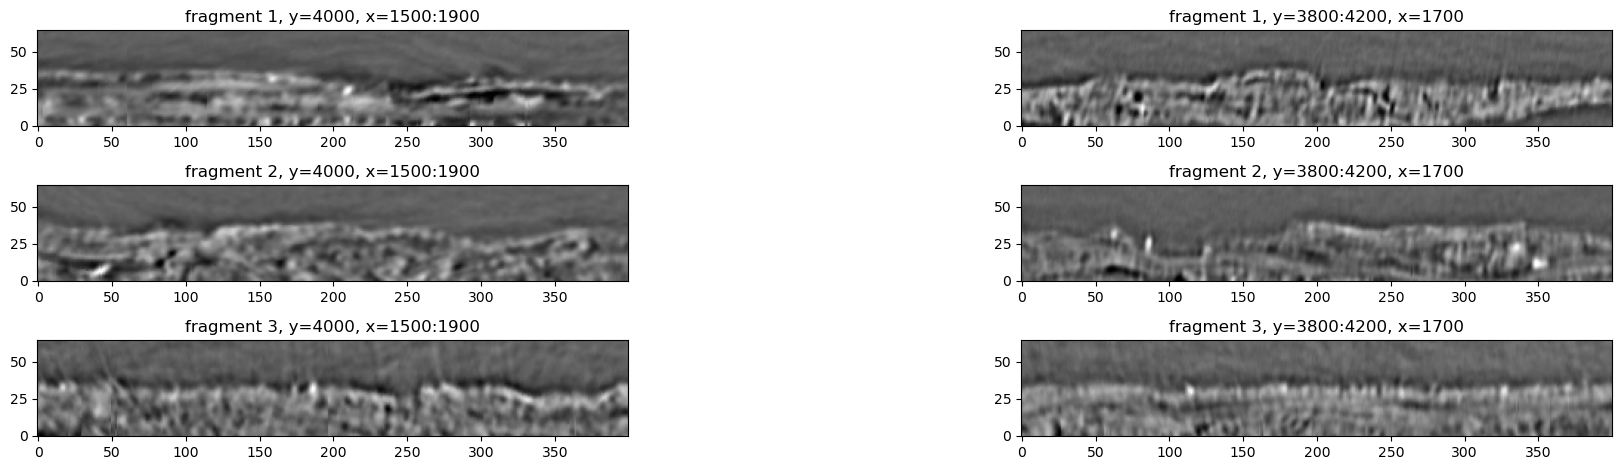

In [8]:
from skimage.filters import gaussian

#visualize cross_sections
def plot_cross_section(ax, scan, y=4000, x=slice(1500, 1900), denoise=False):
    slc = scan.get_img_uint8(x_slc=x, y_slc=y)
    if denoise:
        slc = gaussian(slc)
    ax.imshow(slc, cmap='gray', origin='lower')

fig, ax = plt.subplots(3, 2)
for i, fragment_path in enumerate(train_fragments):
    plot_cross_section(ax[i, 0], ScanData(fragment_path))
    ax[i, 0].set_title(f"fragment {fragment_path.name}, y=4000, x=1500:1900")
    plot_cross_section(ax[i, 1], ScanData(fragment_path), y=slice(3800, 4200), x=1700)
    ax[i, 1].set_title(f"fragment {fragment_path.name}, y=3800:4200, x=1700")
fig.set_figwidth(20)
fig.tight_layout()
plt.savefig("/kaggle/working/fig.png")
plt.show()

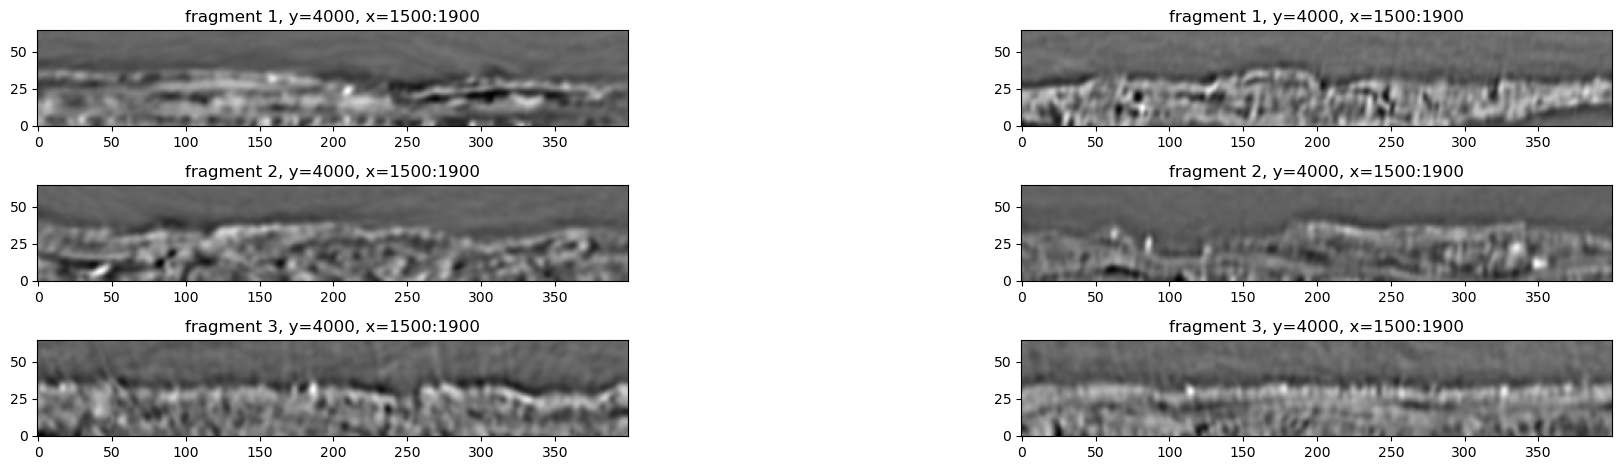

In [10]:
# visiualize denoised
fig, ax = plt.subplots(3, 2)
for i, fragment_path in enumerate(train_fragments):
    plot_cross_section(ax[i, 0], ScanData(fragment_path), denoise=True)
    ax[i, 0].set_title(f"fragment {fragment_path.name}, y=4000, x=1500:1900")
    plot_cross_section(ax[i, 1], ScanData(fragment_path), y=slice(3800, 4200), x=1700, denoise=True)
    ax[i, 1].set_title(f"fragment {fragment_path.name}, y=3800:4200, x=1700")
fig.set_figwidth(20)
fig.tight_layout()
plt.show()